# Import & Settings

In [22]:
import os
import logging
import json
import statistics
import csv
from typing import Optional, Union, List
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm
from collections import defaultdict, Counter
import pathlib
from pathlib import Path

import matplotlib.pyplot as plt
import random

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import BertModel, GPTJForCausalLM, GPT2LMHeadModel
from transformers import PreTrainedTokenizerFast, AutoTokenizer
from transformers.optimization import get_scheduler

import gluonnlp as nlp
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from loss import CrossEntropy, FocalCrossEntropy, label2target
from utils import create_logger, create_directory, increment_path, save_performance_graph

os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://github.com/pytorch/pytorch/issues/57273
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(map(str, range(torch.cuda.device_count())))
os.environ["CUDA_LAUNCH_BLOCKING"] = ",".join(map(str, range(torch.cuda.device_count())))

ROOT = Path(os.getcwd())
DATA = ROOT.parents[1]
save_dir = increment_path(Path(ROOT) / 'runs'/ 'train' / 'exp')

class arguments():
    def __init__(self):
        self.root = DATA / 'data' / '1. 실습용자료_hsp2.txt'
        self.project = save_dir
        self.num_test = 50000
        self.upsample='shuffle'
        self.minimum=100

        self.workers = 4
        self.batch_size = 512
        
        self.model='ensemble'
        self.estimators=10
        self.num_samples=150000
        self.sub_valid_ratio=0.1
        self.epochs=50
        self.patience=5
        self.loss='FCE'
        self.learning_rate=0.1e-4
        self.lr_scheduler='constant_with_warmup'
        self.warmup_step=1000
        self.optimizer='AdamW'
        self.beta1=0.9
        self.beta2=0.99
        self.weight_decay=0.001
        self.eps=1e-8
        self.seed=42
        self.max_len=50
        
        self.device='cuda'
    
args=arguments()

# Data Prepare

## load data

In [23]:
data = pd.read_csv(args.root, sep='|', encoding='utf-8')
display(data.head())
display(data.info())

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal
0,id_0000001,S,95,952,카센터에서,자동차 부분정비,타이어 오일 교환
1,id_0000002,G,47,472,상점 내에서,일반인을 대상으로,채소 과일 판매
2,id_0000003,G,46,467,절단하여 사업체에도 매,공업용 고무를 가지고,합성고무도 매
3,id_0000004,G,47,475,영업점에서,일반 소비자에게,열쇠 잠금장치
4,id_0000005,Q,87,872,어린이집,보호자의 위탁을 받아,취학 전 아동보육


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   AI_id      1000000 non-null  object
 1   digit_1    1000000 non-null  object
 2   digit_2    1000000 non-null  int64 
 3   digit_3    1000000 non-null  int64 
 4   text_obj   983323 non-null   object
 5   text_mthd  956381 non-null   object
 6   text_deal  932345 non-null   object
dtypes: int64(2), object(5)
memory usage: 53.4+ MB


None

In [24]:
# 대-중-소 이어붙이기
def num2code(num, digits=0):
    """ int타입의 데이터를 일정한 자릿수(digits)의 코드값으로 변환 """
    num = str(num)
    code = '0'*(digits-len(num)) + num
    return code

data['digit_2'] = data['digit_2'].apply(lambda x:  num2code(x, 2))
data['digit_3'] = data['digit_3'].apply(lambda x:  num2code(x, 3))
data['digit'] = data['digit_1'] + data['digit_2'] + data['digit_3']
data.head()

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,digit
0,id_0000001,S,95,952,카센터에서,자동차 부분정비,타이어 오일 교환,S95952
1,id_0000002,G,47,472,상점 내에서,일반인을 대상으로,채소 과일 판매,G47472
2,id_0000003,G,46,467,절단하여 사업체에도 매,공업용 고무를 가지고,합성고무도 매,G46467
3,id_0000004,G,47,475,영업점에서,일반 소비자에게,열쇠 잠금장치,G47475
4,id_0000005,Q,87,872,어린이집,보호자의 위탁을 받아,취학 전 아동보육,Q87872


In [25]:
# 중복 행 제거
data = data.drop_duplicates(subset=['text_obj', 'text_mthd', 'text_deal', 'digit'], keep='first')
data

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,digit
0,id_0000001,S,95,952,카센터에서,자동차 부분정비,타이어 오일 교환,S95952
1,id_0000002,G,47,472,상점 내에서,일반인을 대상으로,채소 과일 판매,G47472
2,id_0000003,G,46,467,절단하여 사업체에도 매,공업용 고무를 가지고,합성고무도 매,G46467
3,id_0000004,G,47,475,영업점에서,일반 소비자에게,열쇠 잠금장치,G47475
4,id_0000005,Q,87,872,어린이집,보호자의 위탁을 받아,취학 전 아동보육,Q87872
...,...,...,...,...,...,...,...,...
999993,id_0999994,C,32,320,카본 열선 퀼팅 구조체,조립 배열 봉제하여,의료용 매트리스,C32320
999994,id_0999995,L,68,681,사무실에서,NaN,비주거용 임대,L68681
999995,id_0999996,C,13,134,제품 입고,워싱,청바지 워싱,C13134
999997,id_0999998,G,47,474,영업점에서,일반 소비자에게,여성의류 판매,G47474


## 결측치 처리

In [26]:
# 제출용 데이터의 결측치 분포 확인하기
submit = pd.read_csv(DATA / 'data/2. 모델개발용자료.txt', sep='|', encoding='cp949')
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AI_id      100000 non-null  object 
 1   digit_1    0 non-null       float64
 2   digit_2    0 non-null       float64
 3   digit_3    0 non-null       float64
 4   text_obj   98189 non-null   object 
 5   text_mthd  97032 non-null   object 
 6   text_deal  93839 non-null   object 
dtypes: float64(3), object(4)
memory usage: 5.3+ MB


In [27]:
na_obj = submit['text_obj'].isna()
na_mthd = submit['text_mthd'].isna()
na_deal = submit['text_deal'].isna()
na_text = pd.concat([na_obj, na_mthd, na_deal], axis=1)
na_text.value_counts()

text_obj  text_mthd  text_deal
False     False      False        92985
                     True          2317
          True       True          2294
True      False      True          1550
False     True       False          593
True      False      False          180
          True       False           81
dtype: int64

nan이 없는 데이터 : 92985개

1개만 nan
 - obj만 nan : 180
 - mthd만 nan : 593
 - deal만 nan : 2317
 
2개 nan
 - obj mthd : 81
 - obj deal : 1550
 - mthd deal : 2294
 
nan이 발생하는 모든 경우의 수가 존재

In [28]:
# 결측치 채우기
data = data.fillna('')
data

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,digit
0,id_0000001,S,95,952,카센터에서,자동차 부분정비,타이어 오일 교환,S95952
1,id_0000002,G,47,472,상점 내에서,일반인을 대상으로,채소 과일 판매,G47472
2,id_0000003,G,46,467,절단하여 사업체에도 매,공업용 고무를 가지고,합성고무도 매,G46467
3,id_0000004,G,47,475,영업점에서,일반 소비자에게,열쇠 잠금장치,G47475
4,id_0000005,Q,87,872,어린이집,보호자의 위탁을 받아,취학 전 아동보육,Q87872
...,...,...,...,...,...,...,...,...
999993,id_0999994,C,32,320,카본 열선 퀼팅 구조체,조립 배열 봉제하여,의료용 매트리스,C32320
999994,id_0999995,L,68,681,사무실에서,,비주거용 임대,L68681
999995,id_0999996,C,13,134,제품 입고,워싱,청바지 워싱,C13134
999997,id_0999998,G,47,474,영업점에서,일반 소비자에게,여성의류 판매,G47474


## 레이블 인코딩

In [29]:
# 레이블 인코딩
unique_digit = data['digit'].sort_values().drop_duplicates().tolist()
print('카테고리 개수:', len(unique_digit))
cat2id, id2cat = {}, {}
for i, cat in enumerate(unique_digit):
    cat2id[cat] = i
    id2cat[i] = cat
data['label'] = data['digit'].apply(lambda x: cat2id[x])
data
        
# from sklearn.preprocessing import LabelEncoder
# unique_digit = data['digit'].sort_values().drop_duplicates().tolist()
# print('카테고리 개수:', len(unique_digit))

# le = LabelEncoder()
# le.fit(unique_digit)
# print('첫 5개 카테고리:', list(le.classes_)[:5])
# print('인코딩 id:', le.transform(list(le.classes_)[:5]))

카테고리 개수: 225


,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,digit,label
0,id_0000001,S,95,952,카센터에서,자동차 부분정비,타이어 오일 교환,S95952,221
1,id_0000002,G,47,472,상점 내에서,일반인을 대상으로,채소 과일 판매,G47472,126
2,id_0000003,G,46,467,절단하여 사업체에도 매,공업용 고무를 가지고,합성고무도 매,G46467,123
3,id_0000004,G,47,475,영업점에서,일반 소비자에게,열쇠 잠금장치,G47475,129
4,id_0000005,Q,87,872,어린이집,보호자의 위탁을 받아,취학 전 아동보육,Q87872,212
...,...,...,...,...,...,...,...,...,...
999993,id_0999994,C,32,320,카본 열선 퀼팅 구조체,조립 배열 봉제하여,의료용 매트리스,C32320,90
999994,id_0999995,L,68,681,사무실에서,,비주거용 임대,L68681,168
999995,id_0999996,C,13,134,제품 입고,워싱,청바지 워싱,C13134,26
999997,id_0999998,G,47,474,영업점에서,일반 소비자에게,여성의류 판매,G47474,128


## 학습 데이터 분포 확인

In [30]:
train_dist = data['label'].value_counts().reset_index()
train_dist.columns = ['label', 'cnt']
train_dist

,label,cnt
0,147,62654
1,223,23020
2,128,22092
3,132,21972
4,148,20685
...,...,...
220,11,3
221,138,3
222,164,2
223,6,1


평균: 2850.92
1분위 수: 1.0
2분위 수: 218.0
3분위 수(중앙값): 793.0
4분위 수: 2681.0
5분위 수: 62654.0

box plot


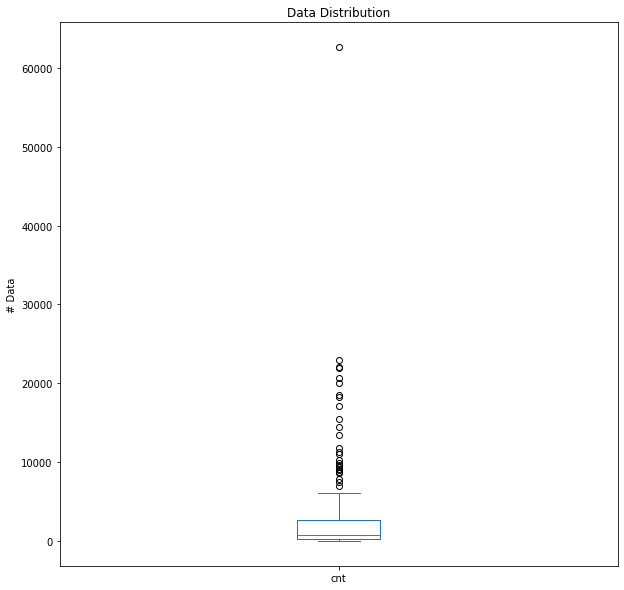

In [31]:
print('평균:', train_dist['cnt'].mean())
print('1분위 수:', train_dist['cnt'].quantile(0))
print('2분위 수:', train_dist['cnt'].quantile(0.25))
print('3분위 수(중앙값):', train_dist['cnt'].quantile(0.5))
print('4분위 수:', train_dist['cnt'].quantile(0.75))
print('5분위 수:', train_dist['cnt'].quantile(1))

print('\nbox plot')
fig = plt.figure(figsize=(10,10))
train_dist['cnt'].plot(kind='box')
plt.title("Data Distribution")
# plt.xlabel("Label")
plt.ylabel("# Data")
plt.show()

## Train Test Split

In [32]:
def train_test_split(frame, test_ratio=0.1, seed=42):
    """
    temp_df 
    """
    train, test = pd.DataFrame(), pd.DataFrame()
    for lb in frame['label'].unique():
        # (lb) 카테고리의 데이터 순서 섞기
        temp_df_l = frame[frame['label']==lb].sample(frac=1, random_state=seed).reset_index(drop=True)
        
        # 데이터 나누기
        if len(temp_df_l) < 3:
            # 데이터 수가 3개 미만인 카테고리는 모두 훈련 데이터로 활용한다. 
            train = pd.concat([train, temp_df_l])
        else:
            # train과 test를 slice할 index 구하기
            if len(temp_df_l) <= 5:
                slice_idx = 1
            elif len(temp_df_l) <= 10:
                slice_idx = 2
            elif len(temp_df_l) < 100:
                a, b = 8/90, 10/9
                slice_idx = int(a*len(temp_df_l) + b)
            else: # len(ttemp) >= 100
                slice_idx = int(len(temp_df_l)*test_ratio)
                
            # train, test 나누기
            train = pd.concat([train, temp_df_l.iloc[slice_idx:, :]])
            test = pd.concat([test, temp_df_l.iloc[:slice_idx, :]])
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)       
    return train, test
test_ratio = args.num_test/len(data)
train, test = train_test_split(data, test_ratio=test_ratio, seed=args.seed)

print('train data 수:', len(train))
print('test data 수:', len(test))

train data 수: 591511
test data 수: 49946


## Sub Sampling with BootStrap : 복원추출

In [33]:
# 카테고리별 데이터 수
dist = train['label'].value_counts().to_frame().reset_index()
dist.columns = ['label', 'cnt']
dist

,label,cnt
0,147,57771
1,223,21226
2,128,20370
3,132,20260
4,148,19073
...,...,...
220,164,2
221,11,2
222,138,2
223,6,1


In [34]:
"""
Train 데이터셋에서 랜덤샘플링해 (args.estimators)개 서브데이터셋을 구성한다..
서브데이터셋은 모든 카테고리를 포함해야 하며, 데이터의 수는 (Train 데이터 수/args.estimators)로 한다.
완전히 random하게 데이터를 샘플하면 데이터가 적은 카테고리를 포함하지 않는 서브데이터셋이 생긴다.
"""

"""
1. Sub sampling을 먼저 한 다음
2. Sub train-valid split
3. Sub train set에 대해서 upsampling 진행(다양한 Upsample 적용)
"""

def bootstrap(data, estimators, num_samples=100000, min_cat_data=2, seed=42):
    def _sub_sampling(data, seed, min_cat_data, t_sampled):
        n = min_cat_data
        e = t_sampled/len(data)
        random.seed(seed)
        sub_data = pd.DataFrame()
        for lb in data['label'].unique().tolist():
            data_lb = data[data['label']==lb].copy()
            seed_lb = random.randint(0, 1000)
            if len(data_lb) <= n:
                n_sampled = len(data_lb)
            else:
                a, b = (100*e-n)/(100-n), 100*n*(1-e)/(100-n)
                n_sampled = int(a*len(data_lb) + b)

    #         if len(data_lb) <= 2:
    #             n_sampled = len(data_lb)
    #         elif len(data_lb) == 3:
    #             n_sampled = 2 # 2개 샘플
    #         elif len(data_lb) <= 5:
    #             n_sampled = len(data_lb)-2 # 2개 빼고 샘플
    #         elif len(data_lb) <= 10:
    #             n_sampled = 5 # 5개 샘플
    #         elif len(data_lb) <= 100:
    #             a, b = (100*e-5)/90, (40-100*e)/9
    #             n_sampled = int(a*len(data_lb) + b)
    #         else: # len(ttemp) >= 100
    #             n_sampled = int(len(data_lb)*e)
            sub_data = pd.concat([sub_data, data_lb.sample(n=n_sampled, random_state=seed_lb)])
            sub_data = sub_data.reset_index(drop=True)
        return sub_data

    sub_data_list = [] # 생성된 서브데이터를 담을 리스트
    for estimator in tqdm(range(estimators), total=estimators): # args.estimators 만큼 서브데이터 생성
        random.seed(seed*estimator)
        seed_i = random.randint(0, 1000)
        sub_data = _sub_sampling(data, seed_i, min_cat_data, num_samples)
        sub_data_list.append(sub_data)
    print('sub data 수:', len(sub_data_list))
    print('sub data 카테고리 수:',
          [(i, len(sub_data['label'].unique())) for i, sub_data in enumerate(sub_data_list)])
    return sub_data_list
sub_data_list = bootstrap(train, args.estimators, num_samples=args.num_samples, min_cat_data=2, seed=args.seed)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.81s/it]

sub data 수: 10
sub data 카테고리 수: [(0, 225), (1, 225), (2, 225), (3, 225), (4, 225), (5, 225), (6, 225), (7, 225), (8, 225), (9, 225)]


In [35]:
# Out of Bag(OOB) : random sampling으로 추출되지 않은 데이터는 테스트 데이터에 포함시킨다.
def out_of_bag(main_data, sub_data_list):
    sub_data_ids = set(pd.concat([sub_data['AI_id'] for sub_data in sub_data_list]).unique())
    main_data_ids = set(main_data['AI_id'].tolist())
    oob_ids = main_data_ids - sub_data_ids
    oob_data = train[train['AI_id'].apply(lambda x: x in oob_ids)]
    oob_data = oob_data.reset_index(drop=True)
    return oob_data
oob_data = out_of_bag(train, sub_data_list)
oob_data

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,digit,label
0,id_0573838,S,95,952,매장에서,고객 의뢰받아,자동차 래핑,S95952,221
1,id_0204165,S,95,952,현대 카센터에서,고객 요구에 의해,자동차 내장 수리 타이어 교체,S95952,221
2,id_0590218,S,95,952,사업장에서,일반 소비자에게,차 오토바이 배터리 전문수리,S95952,221
3,id_0957467,S,95,952,자동차,자동차 종합수리,자동차 수리,S95952,221
4,id_0277033,S,95,952,카센터에서,자동차 특정 부분을 전문수리,타이어,S95952,221
...,...,...,...,...,...,...,...,...,...
38775,id_0761016,C,14,142,모피,재단,옷 제조,C14142,29
38776,id_0551658,C,14,142,밍크 스킨,선별 및 흠집 제거 형태 고정 절단,,C14142,29
38777,id_0760691,C,14,142,모피,재단 봉제 가공하여,모피의류 제조,C14142,29
38778,id_0754942,C,14,142,인조모피,가공,인조 무스탕 가공,C14142,29


In [36]:
# test data에 추가
test = pd.concat([test, oob_data])
test = test.reset_index(drop=True)
test

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal,digit,label
0,id_0195359,S,95,952,세차장에서,고객 요청에 의해,자동차 세차,S95952,221
1,id_0503002,S,95,952,카센터에서,자동차 내장 설치 전문수리,자동차 수리,S95952,221
2,id_0222579,S,95,952,금동 종합 정비 공업사,건설기계장비 및 승용차를 전문적으로,정비 종합 서비스 제공,S95952,221
3,id_0344355,S,95,952,세차장에서,서비스,자동차 세차 광택,S95952,221
4,id_0805317,S,95,952,일반인을 대상으로,가게에서,오토바이 자전거 수리,S95952,221
...,...,...,...,...,...,...,...,...,...
88721,id_0761016,C,14,142,모피,재단,옷 제조,C14142,29
88722,id_0551658,C,14,142,밍크 스킨,선별 및 흠집 제거 형태 고정 절단,,C14142,29
88723,id_0760691,C,14,142,모피,재단 봉제 가공하여,모피의류 제조,C14142,29
88724,id_0754942,C,14,142,인조모피,가공,인조 무스탕 가공,C14142,29


## Column Select

In [37]:
sub_data_list = [sub_data[['label', 'text_obj', 'text_mthd', 'text_deal']]
                  for sub_data in sub_data_list]
test = test[['label', 'text_obj', 'text_mthd', 'text_deal']]
display(sub_data_list[0])
display(test)

,label,text_obj,text_mthd,text_deal
0,221,사업장에서,일반 고객에게,자동차 도색 및 흠집 제거
1,221,세차장에서,고객을 대상으로,차량 세차
2,221,사업장에서,고객에 의뢰를 받아,자동차 선팅
3,221,카센터에서,자동차의 특정 부분만을 전문적 수리,자동차 수리업
4,221,자동차의 특정 부분만을 전문적으로 수리,카센터에서,차량 내부 도장 세차 등의 서비스 제공
...,...,...,...,...
141212,69,사업장에서,LED 광원과 식물재배기술,온실환경제어시스템
141213,69,플라스틱 잉크,자재 입고 사출,교육용 CD
141214,6,무연탄,발파 생산,
141215,22,담뱃잎 담보 잎줄기,원료 투입 슬러리 제조,


,label,text_obj,text_mthd,text_deal
0,221,세차장에서,고객 요청에 의해,자동차 세차
1,221,카센터에서,자동차 내장 설치 전문수리,자동차 수리
2,221,금동 종합 정비 공업사,건설기계장비 및 승용차를 전문적으로,정비 종합 서비스 제공
3,221,세차장에서,서비스,자동차 세차 광택
4,221,일반인을 대상으로,가게에서,오토바이 자전거 수리
...,...,...,...,...
88721,29,모피,재단,옷 제조
88722,29,밍크 스킨,선별 및 흠집 제거 형태 고정 절단,
88723,29,모피,재단 봉제 가공하여,모피의류 제조
88724,29,인조모피,가공,인조 무스탕 가공


## Sub train-valid split

In [38]:
sub_train_list, sub_valid_list = zip(*map(lambda sub_data: train_test_split(
    sub_data, test_ratio=args.sub_valid_ratio, seed=args.seed), sub_data_list))
display(sub_train_list[0].info()) # 첫번째 sub train set
display(sub_valid_list[1].info()) # 두번째 sub valid set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127139 entries, 0 to 127138
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   label      127139 non-null  int64 
 1   text_obj   127139 non-null  object
 2   text_mthd  127139 non-null  object
 3   text_deal  127139 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14078 entries, 0 to 14077
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      14078 non-null  int64 
 1   text_obj   14078 non-null  object
 2   text_mthd  14078 non-null  object
 3   text_deal  14078 non-null  object
dtypes: int64(1), object(3)
memory usage: 440.1+ KB


None

## Upsample sub trainset

In [39]:
def upsample_corpus(df, minimum=500, method='uniform', seed=42):
    random.seed(seed)
    labels = df['label'].unique().tolist()
    upsampled = pd.DataFrame()
    for lb in labels:
        temp_df = df[df['label']==lb].copy()
        n = 0
        while True:
            n+=1
            if n==50:
                import pdb
                pdb.set_trace()
            if len(temp_df)>=minimum:
                break
                
            if method=='random':
                n_sample = minimum-len(temp_df)
                sample = temp_df.sample(n=n_sample, replace=True, random_state=seed)
                not_empty_cond = sample[['text_obj','text_mthd','text_deal']].applymap(
                    lambda x: len(x)!=0).apply(any, axis=1)
                if not not_empty_cond.all():
                    sample = sample[not_empty_cond].reset_index(drop=True)
                temp_df = pd.concat([temp_df, sample])
            elif method=='uniform':
                n_rep = minimum//len(temp_df)
                n_sample = minimum%len(temp_df)
                sample = temp_df.sample(n=n_sample, random_state=seed)
                not_empty_cond = sample[['text_obj','text_mthd','text_deal']].applymap(
                    lambda x: len(x)!=0).apply(any, axis=1)
                if not not_empty_cond.all():
                    sample = sample[not_empty_cond].reset_index(drop=True)
                temp_df = pd.concat([temp_df for _ in range(n_rep)]+[sample])
            elif method=='shuffle':
                s1=random.randrange(0, 1000) # seed 1
                s2=random.randrange(0, 1000) # seed 2
                s3=random.randrange(0, 1000) # seed 3
                n_sample = minimum-len(temp_df)
                sample = pd.concat([
                    temp_df['text_obj'].sample(n=n_sample, replace=True, 
                                               random_state=s1).reset_index(drop=True),
                    temp_df['text_mthd'].sample(n=n_sample, replace=True, 
                                                random_state=s2).reset_index(drop=True),
                    temp_df['text_deal'].sample(n=n_sample, replace=True, 
                                                random_state=s3).reset_index(drop=True)
                ], axis=1)
                sample['label'] = lb
                sample=sample[['label', 'text_obj','text_mthd','text_deal']]
                not_empty_cond = sample[['text_obj','text_mthd','text_deal']].applymap(
                    lambda x: len(x)!=0).apply(any, axis=1)
                if not not_empty_cond.all():
                    sample = sample[not_empty_cond].reset_index(drop=True)
                temp_df=pd.concat([temp_df, sample])
        upsampled = pd.concat([upsampled, temp_df])
    upsampled = upsampled.reset_index(drop=True)
    return upsampled

print('sub train 수(before upsample):\n', 
      [len(sub_train) for sub_train in sub_train_list])
sub_train_list = list(map(
    lambda sub_train: upsample_corpus(sub_train, minimum=args.minimum, method=args.upsample, seed=args.seed),
    sub_train_list
))
print('sub train 수(after upsample):\n', 
      [len(sub_train) for sub_train in sub_train_list])

sub train 수(before upsample):
 [127139, 127139, 127139, 127139, 127139, 127139, 127139, 127139, 127139, 127139]
sub train 수(after upsample):
 [132867, 132867, 132867, 132867, 132867, 132867, 132867, 132867, 132867, 132867]


In [40]:
sub_train_list[0]

,label,text_obj,text_mthd,text_deal
0,221,카센터에서,자동차의 특정 부분을 전문적으로 수리,경정비
1,221,정비소에서,고객을 대상으로,자동차 타이어 수리 서비스
2,221,사업장에서,일반 고객 대상으로,오토바이 수리
3,221,고객을 대상,카센터에서,자동차 수리
4,221,카센터,일반 고객을 대상으로,자동차 전문수리
...,...,...,...,...
132862,22,향료,재료 투입 정제 혼합 출하,
132863,22,향료,재료 투입 정제 혼합 출하,
132864,22,향료,원료 투입 슬러리 제조,
132865,22,향료,원료 투입 슬러리 제조,


## Concatenate Text

In [41]:
def concat_text(data):
    data['text'] = data[['text_obj', 'text_mthd', 'text_deal']].apply(
            lambda text_tuple: ' '.join(text_tuple), axis=1)
    return data

sub_train_list = [concat_text(sub_train) for sub_train in sub_train_list]
sub_valid_list = [concat_text(sub_valid) for sub_valid in sub_valid_list]
test = concat_text(test)

display(sub_train_list[0].head())
display(sub_valid_list[0].head())
display(test.head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,label,text_obj,text_mthd,text_deal,text
0,221,카센터에서,자동차의 특정 부분을 전문적으로 수리,경정비,카센터에서 자동차의 특정 부분을 전문적으로 수리 경정비
1,221,정비소에서,고객을 대상으로,자동차 타이어 수리 서비스,정비소에서 고객을 대상으로 자동차 타이어 수리 서비스
2,221,사업장에서,일반 고객 대상으로,오토바이 수리,사업장에서 일반 고객 대상으로 오토바이 수리
3,221,고객을 대상,카센터에서,자동차 수리,고객을 대상 카센터에서 자동차 수리
4,221,카센터,일반 고객을 대상으로,자동차 전문수리,카센터 일반 고객을 대상으로 자동차 전문수리


,label,text_obj,text_mthd,text_deal,text
0,221,카센터에서,자동차 부분 수리,내장 및 도장,카센터에서 자동차 부분 수리 내장 및 도장
1,221,카센터,자동차 수리 및 검사시설 갖추고,자동차 경정 서비스,카센터 자동차 수리 및 검사시설 갖추고 자동차 경정 서비스
2,221,사업장,자동차,스팀세차,사업장 자동차 스팀세차
3,221,사업장에서,일반 고객 대상으로,차량 세차,사업장에서 일반 고객 대상으로 차량 세차
4,221,카센터에서,특정 부분을 전문적으로 수리,정이 수리 서비스,카센터에서 특정 부분을 전문적으로 수리 정이 수리 서비스


,label,text_obj,text_mthd,text_deal,text
0,221,세차장에서,고객 요청에 의해,자동차 세차,세차장에서 고객 요청에 의해 자동차 세차
1,221,카센터에서,자동차 내장 설치 전문수리,자동차 수리,카센터에서 자동차 내장 설치 전문수리 자동차 수리
2,221,금동 종합 정비 공업사,건설기계장비 및 승용차를 전문적으로,정비 종합 서비스 제공,금동 종합 정비 공업사 건설기계장비 및 승용차를 전문적으로 정비 종합 서비스 제공
3,221,세차장에서,서비스,자동차 세차 광택,세차장에서 서비스 자동차 세차 광택
4,221,일반인을 대상으로,가게에서,오토바이 자전거 수리,일반인을 대상으로 가게에서 오토바이 자전거 수리


# DataLoader

sub dataset의 반은 kobert, 반은 kogpt로 학습

In [42]:
train_loaders = []
valid_loaders = []
if args.model == 'ensemble':
    n_bert = int(args.estimators/2)
    n_gpt = args.estimators - n_bert
elif args.model == 'ensemble-kobert':
    n_bert = args.estimators
    n_gpt = 0
elif args.model == 'ensemble-kogpt2':
    n_bert = 0
    n_gpt = args.estimators
    
print(f'bert base model {n_bert}개')
print(f'gpt base model {n_gpt}개')

bert base model 5개
gpt base model 5개


## Kobert

In [43]:
class KOBERTClassifyDataset(Dataset):
    def __init__(self, doc, label, tokenizer):
        super(KOBERTClassifyDataset, self).__init__()
        self.doc = doc
        self.tokenizer = tokenizer
        self.tokenized = [self.tokenizer([d]) for d in doc] # numpy.array
        self.label = label
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = np.zeros_like(token_ids)
        attention_mask[:valid_length] = 1
        return attention_mask
    
    def __getitem__(self, i):
        token_ids = self.tokenized[i][0]
        valid_length = self.tokenized[i][1]
        token_type_ids = self.tokenized[i][2]
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        return (token_ids, # numpy.array
                attention_mask, # numpy.array
                token_type_ids, # numpy.array
                self.label[i]) # int scalar
        # numpy array will be changed to torch.tensor via DataLoader

    def __len__(self):
        return (len(self.label))
    
bert, bert_vocab = get_pytorch_kobert_model()
bert_tokenizer_path = get_tokenizer()
bert_tokenizer = nlp.data.BERTSPTokenizer(bert_tokenizer_path, bert_vocab, lower=False)
bert_transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=args.max_len, pad=True, pair=False) 

for sub_train, sub_valid in tqdm(zip(sub_train_list[:n_bert], sub_valid_list[:n_bert]),
                                total=n_bert):
    train_set = KOBERTClassifyDataset(sub_train['text'].tolist(),
                                     sub_train['label'].tolist(),
                                     bert_transform)
    valid_set = KOBERTClassifyDataset(sub_valid['text'].tolist(),
                                     sub_valid['label'].tolist(),
                                     bert_transform)
    train_loader = DataLoader(train_set, batch_size=args.batch_size, num_workers=args.workers,
                              shuffle=True, pin_memory=False)
    valid_loader = DataLoader(valid_set, batch_size=args.batch_size, num_workers=args.workers,
                             shuffle=False, pin_memory=False)
    train_loaders.append(train_loader)
    valid_loaders.append(valid_loader)

using cached model. /home/jupyter/parksh/src/.cache/kobert_v1.zip
using cached model. /home/jupyter/parksh/src/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

using cached model. /home/jupyter/parksh/src/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.75s/it]


## KoGPT2

In [44]:
class KOGPT2ClassifyDataset(Dataset):
    def __init__(self, doc, label, tokenizer, max_len):
        super(KOGPT2ClassifyDataset, self).__init__()
        self.doc = doc
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.tokenized = self.tokenizer(doc, padding='max_length', max_length=max_len, truncation=True, return_tensors='pt')
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return (self.tokenized.input_ids[idx],
                self.tokenized.attention_mask[idx],
                self.tokenized.token_type_ids[idx],
                self.label[idx])

gpt_tokenizer = PreTrainedTokenizerFast.from_pretrained(
        'skt/kogpt2-base-v2',
        bos_token='</s>', eos_token='</s>', unk_token='<unk>',
        pad_token='<pad>', mask_token='<mask>')
for sub_train, sub_valid in tqdm(zip(sub_train_list[-n_gpt:], sub_valid_list[-n_gpt:]),
                                total=n_gpt):
    train_set = KOGPT2ClassifyDataset(sub_train['text'].tolist(),
                                     sub_train['label'].tolist(),
                                     gpt_tokenizer, args.max_len)
    valid_set = KOGPT2ClassifyDataset(sub_valid['text'].tolist(),
                                     sub_valid['label'].tolist(),
                                     gpt_tokenizer, args.max_len)
    train_loader = DataLoader(train_set, batch_size=args.batch_size, num_workers=args.workers,
                              shuffle=True, pin_memory=False)
    valid_loader = DataLoader(valid_set, batch_size=args.batch_size, num_workers=args.workers,
                             shuffle=False, pin_memory=False)
    train_loaders.append(train_loader)
    valid_loaders.append(valid_loader)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.47s/it]


In [45]:
print(len(train_loaders))
print(len(valid_loaders))

10
10


# Training Base Model

## Model

In [46]:
class KOBERTClassifier(nn.Module):
    def __init__(self, bert, num_classes, hidden_size = 4096, dr_rate=None, params=None):
        super(KOBERTClassifier, self).__init__()
        self.bert = bert
        self.num_classes = num_classes
        self.dr_rate = dr_rate
         
#         self.classifier = nn.Linear(hidden_size , num_classes)
        self.classifier = nn.Sequential(nn.Linear(768, hidden_size, bias=True),
                                        nn.ReLU(),
                                        nn.Linear(hidden_size, num_classes, bias=True))
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, token_ids, attention_mask, token_type_ids):
        _, pooler = self.bert(input_ids=token_ids.long(),
                              token_type_ids=token_type_ids.long(),
                              attention_mask=attention_mask.float())
        if self.dr_rate:
            pooler = self.dropout(pooler)
        return self.classifier(pooler)
    
class KOGPT2Classifier(nn.Module):
    def __init__(self, gpt, num_classes, hidden_size=4026, freeze_gpt=True, dr_rate=None):
        super(KOGPT2Classifier, self).__init__()
        self.gpt = gpt
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.freeze_gpt = freeze_gpt
        self.dr_rate = dr_rate
        
        # classifier
        self.classifier = nn.Sequential(nn.Linear(768, hidden_size, bias=True, dtype=torch.float32),
                                        nn.ReLU(),
                                        nn.Linear(hidden_size, num_classes, bias=True, dtype=torch.float32))
        
        if self.dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def forward(self, token_ids, attention_mask, token_type_ids):
        # transformer decoder output
        # size : (b, n_dec_seq, n_hidden)
        dec_output = self.gpt.transformer(input_ids=token_ids,
                                  token_type_ids=token_type_ids,
                                  attention_mask = attention_mask)
        
        # language model output
        # size : (b, n_dec_seq, n_dec_vocab)
        logits_lm = self.gpt.lm_head(dec_output.last_hidden_state)
        
        # classifier output
        # size : (b, n_hidden)
        dec_outputs = dec_output.last_hidden_state[:, -1].contiguous() # 마지막 예측 토큰을 분류값으로 사용
        # size : (b, num_classes)
        logits_cls = self.classifier(dec_outputs)
        
#         return logits_lm[:, :-1, :].contiguous(), logits_cls, dec_output.attentions
        return logits_cls

gpt = GPT2LMHeadModel.from_pretrained(
    pretrained_model_name_or_path='skt/kogpt2-base-v2',
    pad_token_id=gpt_tokenizer.eos_token_id, torch_dtype='auto',
    low_cpu_mem_usage=True)

for child in gpt.children():
    for param in child.parameters():
        param.requires_grad = False

## Optimizer, Loss

In [47]:
def get_optimizer(optimizer_type, model, lr, betas, weight_decay, eps=1e-08, amsgrad=False):
    if optimizer_type == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad)
    elif optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad)
    elif optimizer_type == 'RAdam':
        optimizer = torch.optim.RAdam(model.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad)
    else:
        raise
    return optimizer

def get_loss(loss_type, **kwargs):
    if loss_type == 'CE':
        criterion = CrossEntropy(**kwargs)
    elif loss_type == 'FCE':
        criterion = FocalCrossEntropy(**kwargs)
    else:
        raise
    return criterion

## Train

In [ ]:
# save config
create_directory(args.project)
print('output_path:', args.project)
with open(args.project / 'config.json', 'w', encoding='utf-8-sig') as f:
    arg_dict = {k: (str(v) if type(v)==pathlib.PosixPath else v) for k, v in args.__dict__.items()}
    json.dump(arg_dict, f, indent=4)
        
num_classes = len(cat2id)
for e in range(args.estimators):
    patience = 0
    model_args = arguments()
    model_args.project = args.project / f'model{e}'
    create_directory(model_args.project / 'weights')
    logger = create_logger(model_args.project, file_name='log.txt')
    
    # dataset
    train_loader = train_loaders[e]
    valid_loader = valid_loaders[e]
    logger.info(f'# train data: {len(train_loader.dataset)}')
    logger.info(f'# valid data: {len(valid_loader.dataset)}')
    
    # build model
    if e <= n_bert:
        model_args.model = 'kobert'
        model = KOBERTClassifier(bert=bert, num_classes=num_classes)
    else:
        model_args.model = 'kogpt2'
        model = KOGPT2Classifier(gpt=gpt, num_classes=num_classes)
    model = model.to(args.device)
    
    # save config
    with open(model_args.project / 'config.json', 'w', encoding='utf-8-sig') as f:
        arg_dict = {k: (str(v) if type(v)==pathlib.PosixPath else v) for k, v in model_args.__dict__.items()}
        json.dump(arg_dict, f, indent=4)
    
    # optimizer
    optimizer = get_optimizer(args.optimizer, model, args.learning_rate,
                              (args.beta1, args.beta2), args.weight_decay, eps=1e-08, amsgrad=False)
    
    # lr scheduler
    t_total = len(train_loader) * args.epochs
    scheduler = get_scheduler(name=args.lr_scheduler, optimizer=optimizer, 
                              num_warmup_steps=args.warmup_step, num_training_steps=t_total)\
    
    criterion = get_loss(args.loss)
    
    best_acc = None
    best_loss = None
    for epoch in range(args.epochs):
        # train
        train_loss = 0
        model.train()
        for (input_ids, attention_mask, token_type_ids, label) in tqdm(train_loader, total=len(train_loader)):
            input_ids = input_ids.to(args.device, non_blocking=True)
            attention_mask = attention_mask.to(args.device, non_blocking=True)
            token_type_ids = token_type_ids.to(args.device, non_blocking=True)

            # forward propagation
            output = model(input_ids, attention_mask, token_type_ids)
            target = label2target(output, label).to(args.device, non_blocking=True)
            loss = criterion(output, target)

            # backward propagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            scheduler.step()  # Update learning rate schedule

            train_loss += float(loss)*len(label)
        train_loss /= len(train_loader.dataset)
        
        # validation
        valid_loss = 0
        class_scores = defaultdict(list)
        predictions = []
        valid_confusion_matrix = np.zeros((model.num_classes, model.num_classes), dtype=np.int64)

        model.eval()
        with torch.no_grad():
            for (input_ids, attention_mask, token_type_ids, label) in tqdm(valid_loader, total=len(valid_loader)):
                input_ids = input_ids.to(args.device, non_blocking=True)
                attention_mask = attention_mask.to(args.device, non_blocking=True)
                token_type_ids = token_type_ids.to(args.device, non_blocking=True)

                # forward propagation
                output = model(input_ids, attention_mask, token_type_ids)
                target = label2target(output, label).to(args.device, non_blocking=True)
                loss = criterion(output, target)
                valid_loss += float(loss)*len(label)


                # get confusion matrix
                pred = torch.argmax(output, 1).cpu()
                valid_confusion_matrix += confusion_matrix(label, pred, labels=list(range(model.num_classes)))
                predictions += pred.tolist()

            valid_loss /= len(valid_loader.dataset)
            acc = np.diagonal(valid_confusion_matrix).sum() / valid_confusion_matrix.sum()
            for c in range(len(valid_confusion_matrix)):
                num_pred = valid_confusion_matrix[:, c].sum()
                num_true = valid_confusion_matrix[c].sum()
                TP = valid_confusion_matrix[c, c]
                FP = num_true - TP
                FN = num_pred - TP
                PC = TP/num_pred if num_pred != 0 else 0 # TP / (TP+FP)
                RC = TP/num_true if num_true != 0 else 0  # TP / (TP+FN)
                F1 = 2 * PC * RC / (PC + RC) if PC + RC != 0 else 0 # (2 * PC * RC) / (PC + RC)
                class_scores['class_id'].append(c)
                class_scores['precision'].append(PC)
                class_scores['recall'].append(RC)
                class_scores['f1score'].append(F1)
        
        # logging scores
        macro_pc = statistics.mean(class_scores['precision'])
        macro_rc = statistics.mean(class_scores['recall'])
        macro_f1 = statistics.mean(class_scores['f1score'])
        logger.info(f'Epoch {epoch} Result')
        logger.info(f'\ttrain loss: {train_loss}\tvalid_loss: {valid_loss}')
        logger.info(f'\tacc: {round(acc, 6)}\tpc: {round(macro_pc, 6)}\trc: {round(macro_rc, 6)}\tf1: {round(macro_f1, 6)}')
        
        # save scores
        if epoch==0:
            # summary.csv
            with open(model_args.project / 'summary.csv', 'w', newline='') as f:
                wr = csv.writer(f)
                wr.writerow(['epoch', 'train loss', 'valid loss', 'accuracy', 'precision', 'recall', 'f1score'])
            # base frame for precisions, recalls and f1scores
            class_id = list(set(train_loader.dataset.label))
            num_train_data, num_valid_data = [0] * len(class_id), [0] * len(class_id)
            for c_id, n in dict(Counter(train_loader.dataset.label)).items():
                num_train_data[c_id] = n
            for c_id, n in dict(Counter(valid_loader.dataset.label)).items():
                num_valid_data[c_id] = n
            history_frame = defaultdict(lambda: pd.DataFrame({
                'class_id': class_id,
                'class': list(map(lambda x: ''.join(id2cat[x]), class_id)),
                '# train data' : num_train_data,
                '# valid data' : num_valid_data
            }))
        
        # add new line to summary.csv
        with open(model_args.project / 'summary.csv', 'a', newline='') as f:
            wr = csv.writer(f)
            wr.writerow([epoch, train_loss, valid_loss, acc, macro_pc, macro_rc, macro_f1])
            
        # add new column(epoch) to precision.csv, recall.csv and f1score.csv
        for metric, values in class_scores.items():
            if metric != 'class_id':
                history_frame[metric][f'epoch {epoch}'] = 0
                for c_id, v in zip(class_scores['class_id'], values):
                    r = history_frame[metric][history_frame[metric]['class_id']==c_id][f'epoch {epoch}'].index
                    history_frame[metric].loc[r, f'epoch {epoch}'] = v
                history_frame[metric].to_csv(model_args.project / f'{metric}.csv', encoding='utf-8-sig', index=False)
        
        # save performance graph
        save_performance_graph(model_args.project / 'summary.csv', model_args.project / 'performance.png')
        
        # model save
        epoch_score = acc
        torch.save({'state_dict': model.classifier.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    'best acc': acc if best_acc is None or acc > best_acc else best_acc,
                    'best loss': valid_loss if best_loss is None or valid_loss <= best_loss else best_loss,
                    'epoch': epoch},
                   model_args.project / 'weights' / 'checkpoint.pth.tar')
        
        if best_acc is None or acc > best_acc: 
            logger.info(f'Validation accuracy got better {best_acc} --> {acc}.  Saving model ...')
            shutil.copyfile(model_args.project / 'weights' / 'checkpoint.pth.tar',
                            model_args.project / 'weights' / 'best_acc.pth.tar')
            best_acc = acc
            
            # save valid predictions
            pred_frame = pd.DataFrame({
                "doc": valid_loader.dataset.doc,
                "category": list(map(lambda x: ''.join(id2cat[x]), valid_loader.dataset.label)),
                "predictions": list(map(lambda x: ''.join(id2cat[x]), predictions))
            })
            pred_frame.to_csv(model_args.project / 'best_acc_predictions.csv', encoding='utf-8-sig', index=False)
        
        if best_loss is None or valid_loss <= best_loss:
            logger.info(f'Validation loss got better {best_loss} --> {valid_loss}.  Saving model ...')
            shutil.copyfile(model_args.project / 'weights' / 'checkpoint.pth.tar',
                            model_args.project / 'weights' / 'best_loss.pth.tar')
            best_loss = valid_loss
            
            # save valid predictions
            pred_frame = pd.DataFrame({
                "doc": valid_loader.dataset.doc,
                "category": list(map(lambda x: ''.join(id2cat[x]), valid_loader.dataset.label)),
                "predictions": list(map(lambda x: ''.join(id2cat[x]), predictions))
            })
            pred_frame.to_csv(model_args.project / 'best_loss_predictions.csv', encoding='utf-8-sig', index=False)
            patience = 0
        else:
            logger.info(f'patience {patience} --> {patience+1}')
            patience += 1
        
        if patience >= args.patience:
            logger.info('Early Stop!')
            break
            

2022-04-02 15:18:51,553 | # train data: 132867
2022-04-02 15:18:51,553 | # valid data: 14078


output_path: /home/jupyter/parksh/src/runs/train/exp20


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.25it/s]
2022-04-02 15:21:39,471 | Epoch 0 Result
2022-04-02 15:21:39,472 | 	train loss: 5.218450851943297	valid_loss: 4.835611374951642
2022-04-02 15:21:39,472 | 	acc: 0.097812	pc: 0.000435	rc: 0.004444	f1: 0.000792
2022-04-02 15:21:40,649 | Validation accuracy got better None --> 0.09781218923142491.  Saving model ...
2022-04-02 15:21:41,072 | Validation loss got better None --> 4.835611374951642.  Saving model ...
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.20it/s]
2022-04-02 15:24:28,926 | Epoch 1 Result
2022-04-02 15:24:28,927 | 	train loss: 4.338412347397214	valid_loss: 3.653929253670451
2022-04-02 15:24:28,927 | 	acc: 0.151726	pc: 0.003464	rc: 0.014452	f1: 0.005188
2022-04-02 15:24:30,412 | Validation accuracy got better 0.09781218923142491 --> 0.15172609745702514.  Saving model ..

2022-04-02 15:53:16,144 | Validation loss got better 0.49746638152863193 --> 0.4781576398421899.  Saving model ...
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.16it/s]
2022-04-02 15:56:06,761 | Epoch 12 Result
2022-04-02 15:56:06,762 | 	train loss: 0.3528400549830418	valid_loss: 0.47690179703977065
2022-04-02 15:56:06,762 | 	acc: 0.844225	pc: 0.665884	rc: 0.616515	f1: 0.621252
2022-04-02 15:56:08,244 | Validation accuracy got better 0.8393237675806222 --> 0.8442250319647677.  Saving model ...
2022-04-02 15:56:08,963 | Validation loss got better 0.4781576398421899 --> 0.47690179703977065.  Saving model ...
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.16it/s]
2022-04-02 15:58:59,374 | Epoch 13 Result
2022-04-02 15:58:59,375 | 	train loss: 0.3201561112674629	valid_loss: 0.46337868180324415
2022-04-02 15:58:59,375 | 	acc: 0.847919	pc: 0

# Ensemble

backbone bert, gpt 필요

## Load Base Models

In [ ]:
bert_classifiers, gpt_classfiers = [], []

bert_classifier = nn.Sequential(nn.Linear(768, 4096, bias=True),
                                        nn.ReLU(),
                                        nn.Linear(4096, num_classes, bias=True))
gpt_classifier = nn.Sequential(nn.Linear(768, hidden_size, bias=True, dtype=torch.float32),
                                        nn.ReLU(),
                                        nn.Linear(4096, num_classes, bias=True, dtype=torch.float32))

for e in tqdm(range(args.estimators), total=args.estimators):
    checkpoint = torch.load(args.root / f'model{e}/weights/best_loss.pth.tar',
                            map_location=args.device)
    with open(args.root / f'model{e}' / 'config.json', 'r') as f:
        checkpoint_args = json.load(f)
        model_type = checkpoint_args['model']
    
    if model_type=='kobert':
        bert_classifiers.append(
            bert_classifier.copy().load_state_dict(checkpoint['state_dict'])
        )
    else: # kogpt2
        gpt_classfiers.append(
            gpt_classifier.copy().load_state_dict(checkpoint['state_dict'])
        )
        
print(len(bert_classifiers))
print(len(gpt_classifiers))

## Build Ensemble Model

In [ ]:
class EnsembleClassifier(nn.Module):
    def __init__(self, num_classes,
                 bert=None,
                 gpt=None,
                 bert_classifiers=[],
                 gpt_classifiers=[],
                 aggregation='mean_softmax',
                 stacking=None
                ):
        self.num_classes=num_classes
        self.bert=bert
        self.gpt=gpt
        self.bert_classifiers=bert_classifiers
        self.gpt_classifiers=gpt_classfiers
        self.aggregation=aggregation
        if aggregation='mean_softmax':
            self.aggregation_fn=self.mean_softmax
        elif aggregation='sum_argmax':
            self.aggregation_fn=self.sum_argmax
            
        for child in self.bert.children():
            for param in child.parameters():
                param.requires_grad = False
                
        for child in self.gpt.children():
            for param in child.parameters():
                param.requires_grad = False
        
    def mean_softmax(self, tensor, dim=1):
        return tensor.mean(dim)
    
    def sum_argmax(self, tensor, dim=1):
        max_idx = torch.argmax(tensor, dim, keepdim=True)
        one_hot = torch.FloatTensor(tensor.shape)
        one_hot.zero_()
        one_hot.scatter_(dim, max_idx, 1)
        return one_hot
            
        
    def forward(self, token_ids, attention_mask, token_type_ids):
        output = []
        # bert output
        if self.bert:
            bert_output = torch.tensor()
            _, pooler = self.bert(input_ids=token_ids.long()[:,0].clone(),
                                  token_type_ids=token_type_ids.long()[:,0].clone(),
                                  attention_mask=attention_mask.float()[:,0].clone())
            if self.dr_rate:
                pooler = self.dropout(pooler)
            output += [
                F.softmax(classifier(pooler), dim=1) for classifier in self.bert_classifiers
            ]
            
        if self.gpt:
            dec_output = self.gpt.transformer(input_ids=token_ids[:,1],
                                      token_type_ids=token_type_ids[:,1],
                                      attention_mask = attention_mask[:,1])
            dec_outputs = dec_output.last_hidden_state[:, -1].contiguous() # 마지막 예측 토큰을 분류값으로 사용
            output +=  [
                F.softmax(classifier(pooler), dim=1) for classifier in self.gpt_classifiers
            ]
            
        output = torch.cat(output, dim=1)
        aggregated = self.aggregation_fn(output)
        return aggregated
    
    
ensemble = EnsembleClassifier(num_classes,
                             bert=bert,
                             gpt=gpt,
                             bert_classifiers=bert_classifiers,
                             gpt_classifiers=gpt_classifiers,
                             aggregation='mean_softmax',
                             stacking=None)

## Test Loader

In [ ]:
class EnsembleDataset(Dataset):
    def __init__(self, doc, label, kobert_tokenizer, kogpt_tokenizer
                 max_len=50, padding='max_length', truncation=True):
        super(EnsembleDataset, self).__init__()
        self.doc = doc
        
        self.kobert_tokenizer = kobert_tokenizer
        self.kogpt_tokenizer = kogpt_tokenizer
        self.kobert_tokenized = [self.kobert_tokenizer([d]) for d in doc] # numpy.array
        self.kogpt_toknized = self.kogpt_tokenizer(doc, padding=padding, max_length=max_len, truncation=truncation, return_tensors='pt')
        self.label = label
        
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = np.zeros_like(token_ids)
        attention_mask[:valid_length] = 1
        return attention_mask
    
    def __getitem__(self, idx):
        kobert_token_ids = self.kobert_tokenized[idx][0]
        kobert_valid_length = self.kobert_tokenized[idx][1]
        kobert_token_type_ids = self.kobert_tokenized[idx][2]
        kobert_attention_mask = self.gen_attention_mask(kobert_token_ids, kobert_valid_length)
        
        kogpt_token_ids = self.kogpt_toknized.input_ids[idx]
        kogpt_attention_mask = self.kogpt_toknized.attention_mask[idx]
        kogpt_token_type_ids = self.kogpt_toknized.token_type_ids[idx]
        
        return (torch.cat([torch.from_numpy(kobert_token_ids).unsqueeze(0), kogpt_token_ids.unsqueeze(0)], dim=0), # token_ids
                torch.cat([torch.from_numpy(kobert_attention_mask).unsqueeze(0), kogpt_attention_mask.unsqueeze(0)], dim=0), # attention_mask
                torch.cat([torch.from_numpy(kobert_token_type_ids).unsqueeze(0), kogpt_token_type_ids.unsqueeze(0)], dim=0), # token_type_ids
                self.label[idx]) # int scalar

    def __len__(self):
        return (len(self.label))
    
test_set = EnsembleDataset(test['test'].tolist(), test['label'].tolist(),
                          kobert_tokenizer=bert_tokenizer, kogpt_tokenizer=gpt_tokenizer,
                          max_len=args.max_len)
test_loader = DataLoader(test_set, batch_size=args.batch_size, num_workers=args.workers,
                         shuffle=False, pin_memory=False)

## Ensemble Test

In [ ]:
logger = create_logger(args.project, file_name='log.txt')
logger.info('# test data:', len(test_loader.dataset))

ensemble = ensemble.to(args.device)
ensemble.eval()
test_loss = 0
class_scores = defaultdict(list)
predictions = []
test_confusion_matrix = np.zeros((ensemble.num_classes, ensemble.num_classes), dtype=np.int64)

ensemble.eval()
with torch.no_grad():
    for (input_ids, attention_mask, token_type_ids, label) in tqdm(test_loader, total=len(test_loader)):
        input_ids = input_ids.to(args.device, non_blocking=True)
        attention_mask = attention_mask.to(args.device, non_blocking=True)
        token_type_ids = token_type_ids.to(args.device, non_blocking=True)

        # forward propagation
        output = ensemble(input_ids, attention_mask, token_type_ids)
        target = label2target(output, label).to(args.device, non_blocking=True)
        loss = criterion(output, target)
        test_loss += float(loss)*len(label)


        # get confusion matrix
        pred = torch.argmax(output, 1).cpu()
        test_confusion_matrix += confusion_matrix(label, pred, labels=list(range(ensemble.num_classes)))
        predictions += pred.tolist()

    test_loss /= len(test_loader.dataset)
    acc = np.diagonal(test_confusion_matrix).sum() / test_confusion_matrix.sum()
    for c in range(len(test_confusion_matrix)):
        num_pred = test_confusion_matrix[:, c].sum()
        num_true = test_confusion_matrix[c].sum()
        TP = test_confusion_matrix[c, c]
        FP = num_true - TP
        FN = num_pred - TP
        PC = TP/num_pred if num_pred != 0 else 0 # TP / (TP+FP)
        RC = TP/num_true if num_true != 0 else 0  # TP / (TP+FN)
        F1 = 2 * PC * RC / (PC + RC) if PC + RC != 0 else 0 # (2 * PC * RC) / (PC + RC)
        class_scores['class_id'].append(c)
        class_scores['precision'].append(PC)
        class_scores['recall'].append(RC)
        class_scores['f1score'].append(F1)

# logging scores
macro_pc = statistics.mean(class_scores['precision'])
macro_rc = statistics.mean(class_scores['recall'])
macro_f1 = statistics.mean(class_scores['f1score'])
logger.info(f'\ttest_loss: {valid_loss}')
logger.info(f'\tacc: {round(acc, 6)}\tpc: {round(macro_pc, 6)}\trc: {round(macro_rc, 6)}\tf1: {round(macro_f1, 6)}')

# summary.csv
with open(args.project / 'test_result.csv', 'w', newline='') as f:
    wr = csv.writer(f)
    wr.writerow(['test_loss', 'accuracy', 'precision', 'recall', 'f1score'])
# base frame for precisions, recalls and f1scores
class_id = list(set(train_loader.dataset.label))
num_test_data = [0] * len(class_id)
for c_id, n in dict(Counter(test_loader.dataset.label)).items():
    num_test_data[c_id] = n
history_frame = pd.DataFrame({
    'class_id': class_id,
    'class': list(map(lambda x: ''.join(id2cat[x]), class_id)),
    '# test data' : num_test_data
})
            
# add new line to summary.csv
with open(args.project / 'test_result.csv', 'a', newline='') as f:
    wr = csv.writer(f)
    wr.writerow([test_loss, acc, macro_pc, macro_rc, macro_f1])

# add new column(epoch) to precision.csv, recall.csv and f1score.csv
for metric, values in class_scores.items():
    if metric != 'class_id':
        history_frame[metric] = 0
        for c_id, v in zip(class_scores['class_id'], values):
            r = history_frame[history_frame['class_id']==c_id][metric].index
            history_frame[metric].loc[r, metric] = v
        history_fram.to_csv(args.project / f'test_result_verbose.csv', encoding='utf-8-sig', index=False)
                
# save valid predictions
pred_frame = pd.DataFrame({
    "doc": test_loader.dataset.doc,
    "category": list(map(lambda x: ''.join(id2cat[x]), test_loader.dataset.label)),
    "predictions": list(map(lambda x: ''.join(id2cat[x]), predictions))
})
pred_frame.to_csv(args.project / 'predictions.csv', encoding='utf-8-sig', index=False)


# Stacking

input : (args.estimator)개 모델의 output을 개별 feature의 관측치라고 본다..

model : 뉴럴 네트워크 뿐만 아니라 일반적인 분류 모델 ex) decision tree 등 사용 가능할 듯.